# Exercise 1 - Smoothing and Interpolation

## Introduction
This exercise is about smoothing and interpolating medical images using B-spline basis functions. First, you will implement the principle on a one-dimensional signal, and then expand it to an image in 2D.

### Instructions for your report
Your report should be structured as follows:
* **Introduction**: a short summary of what your report is about, perhaps with a recap of some of the equations you'll be using in your solution.
* **Task 1, ..., 5**: for each specific task listed below, your code (in code cells), your results (as figures) as well as explanations of what is computed and what is shown in the figures (in Markdown cells). 
* **Conclusion**: a short summary of your findings.

This introduction should **not** be part of your report.

### Input data and code hints
Import Python libraries

In [1]:
import numpy as np
import nibabel as nib
from matplotlib import pyplot as plt

np.set_printoptions( suppress=True )
plt.style.use('dark_background') # Dark theme
plt.ion()

Read a 3D image (an MRI scan of the brain) and extract the 2D slice you'll be working with in this exercise:

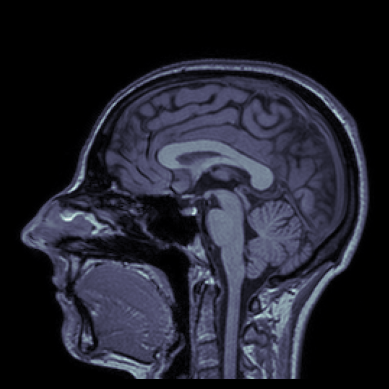

In [2]:
T1_file = '/Users/alexandrumarin/Documents/DTU/3rd semester/Medical Image Analysis/report1/IXI002-Guys-0828-MPRAGESEN_-s256_-0301-00003-000001-01.nii'
T1_nib = nib.load( T1_file )
data = T1_nib.get_fdata()

img = data[:, :, 75]
T = np.flipud( img.T )

plt.axis('off')
plt.imshow(T, cmap='bone');

Extract the 1D signal you'll be working with as the middle row of the 2D image

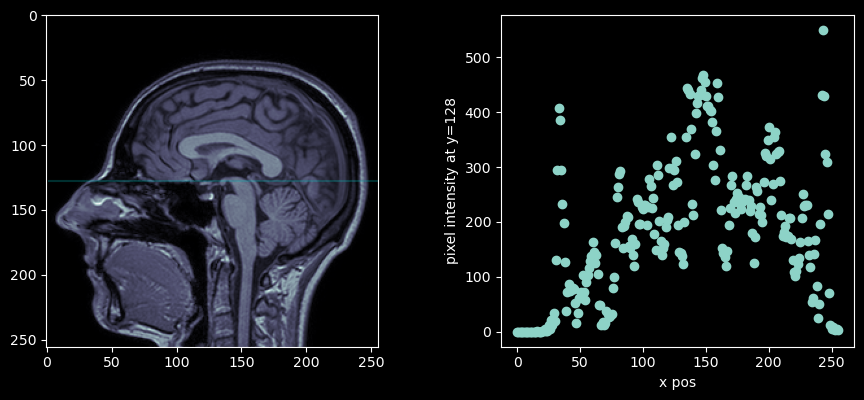

In [3]:
row = round( T.shape[0] / 2 )
t = T[row, :] #pixel intensity at row y = 128

N = t.shape[0]
x = np.arange(0, N)

# plot
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10,5))
fig.tight_layout(pad=5.0)

ax[0].imshow(T, cmap='bone')
ax[0].hlines(row, xmin=1, xmax=255, alpha=0.25, color='c')

ax[1].scatter(x, t)
ax[1].set_xlabel('x pos')
ax[1].set_ylabel('pixel intensity at y={}'.format(row))

plt.show();

---
## Task 1: B-splines basis functions
Implement a function that evaluates the uniform B-spline of orders 0, 1 and 3 at the locations provided in a vector $\mathbf{x}$. 

The function should return a vector $\mathbf{y}$ that is the same length as $\mathbf{x}$:

    def eval_BSpline(x, order=0):

        """
        Evaluates the uniform B-spline of order "order" at the locations in vector "x"
        """

        ...

        return y


Use this function to plot the uniform B-spline of orders 0, 1 and 3 at locations:  $\mathbf{x} = [-3.0,-2.99,-2.98, \ldots, 2.99,3.0]$

> ***Hint:*** use the function ```np.arange()``` to obtain $\mathbf{x}$.

In [4]:
# def beta0(x):
#     y = np.zeros_like(x)
#     y[(x > -0.5) & (x < 0.5)] = 1
#     y[(abs(x) == 0.5)] = 0.5
#     return y

# def normalize(x, y):
#     return x / (np.sum(x) * y)

# def eval_BSpline(x, order=0):
#     """
#     Evaluates the uniform B-spline of order "order" at the locations in vector "x"
#     """
#     dx = x[1] - x[0]

#     if order == 0:
#         y = beta0(x)

#     elif order == 1:
#         y = np.convolve(beta0(x), beta0(x), mode='same')
#         y = normalize(y, dx)

#     elif order == 3:
#         y = np.convolve(np.convolve(np.convolve(beta0(x), beta0(x), mode='same'), beta0(x), mode='same'), beta0(x), mode='same')
#         y = normalize(y, dx)

#     else:
#         raise ValueError('Order not supported')

#     return y


# x = np.arange(-3.0, 3.01, 0.01)

# y_order_0 = eval_BSpline(x, order=0)
# y_order_1 = eval_BSpline(x, order=1)
# y_order_3 = eval_BSpline(x, order=3)

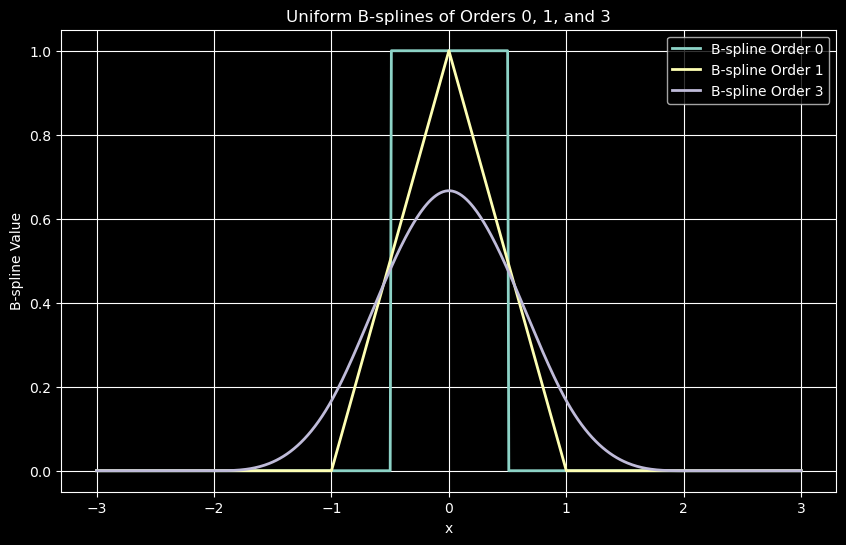

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def eval_BSpline(x, order=0):
    """
    Evaluates the uniform B-spline of order "order" at the locations in vector "x"
    """

    if order == 0:
        y = np.zeros_like(x)
        y[(x > -0.5) & (x < 0.5)] = 1
        y[(abs(x) == 0.5)] = 0.5

    elif order == 1:
        y = np.zeros_like(x)
        mask = abs(x) < 1
        y[mask] = 1 - abs(x[mask])
        y[abs(x) >= 1] = 0 

    elif order == 3:
        y = np.zeros_like(x)
        mask1 = abs(x) < 1
        y[mask1] = 2/3 - abs(x[mask1])**2 + 0.5 * abs(x[mask1])**3
        mask2 = (abs(x) >= 1) & (abs(x) < 2)
        y[mask2] = (2 - abs(x[mask2]))**3 / 6
        y[abs(x) >= 2] = 0

    else:
        raise ValueError('Order not supported')

    return y

x = np.arange(-3.0, 3.01, 0.01)

y_order_0 = eval_BSpline(x, order=0)
y_order_1 = eval_BSpline(x, order=1)
y_order_3 = eval_BSpline(x, order=3)

plt.figure(figsize=(10, 6))

plt.plot(x, y_order_0, label="B-spline Order 0", linewidth=2)
plt.plot(x, y_order_1, label="B-spline Order 1", linewidth=2)
plt.plot(x, y_order_3, label="B-spline Order 3", linewidth=2)

plt.title("Uniform B-splines of Orders 0, 1, and 3")
plt.xlabel("x")
plt.ylabel("B-spline Value")
plt.legend()
plt.grid(True)
plt.show()

---
## Task 2: Smoothing
Using the function you wrote above for evaluating a uniform B-spline of order 3, generate $M=6$ basis functions covering the entire domain $x=0,1,\ldots, 255$ of the 1D signal $\mathbf{t}$ defined in the introduction (which has length $N=256$). 

The basis functions should be scaled by a factor $h=(N-1)/(M-1)$, and shifted to be $h$ units apart (see book). 

Collect the obtained basis functions in a $N \times M$ matrix $\boldsymbol{\Phi}$, and plot them.

In [6]:
# def getvalueFrom0(a):
#     b=0
#     if (0.5 > a > -0.5):
#         b=1
#     elif a**2==0.25:
#         b=0.5    
#     return b

# def eval_BSpline(x, order=3):
#     """
#     Evaluates the uniform B-spline of order "order" at the locations in vector "x"
#     """
#     y=[]

#     for i in x:
#         y.append(getvalueFrom0(i))
    
#     if order==0:
#         return y
#     else:
#         y_order= y
#         delta_x=x[2]-x[1]
        
#         while order>0:
#             y_order_new=[]
#             for i in range(len(x)):
#                 y_order_new.append(np.sum(y_order[j]*getvalueFrom0(x[i]-x[j])*delta_x for j in range(len(x))))
#             order=order-1
#             y_order=y_order_new
#         return y_order

[[0.66666667 0.16666667 0.         0.         0.         0.        ]
 [0.66628597 0.17665905 0.00000126 0.         0.         0.        ]
 [0.66515895 0.18701329 0.00001005 0.         0.         0.        ]
 ...
 [0.         0.         0.         0.00001005 0.18701329 0.66515895]
 [0.         0.         0.         0.00000126 0.17665905 0.66628597]
 [0.         0.         0.         0.         0.16666667 0.66666667]]


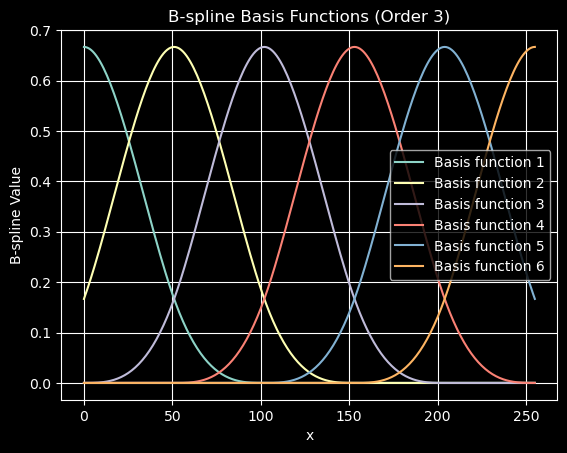

In [7]:
x = np.arange(0,256) 
N = x.shape[0]
M = 6   
h = (N - 1) / (M - 1)  
x = x/h

# Generate the matrix Phi 
Phi = np.zeros((N, M))

for i in range(M):
    Phi[:,i] = eval_BSpline(x-i, order=3)

print(Phi)
# Plot the basis functions
plt.figure()

for m in range(M):
    plt.plot(Phi[:, m], label=f"Basis function {m+1}")

plt.title("B-spline Basis Functions (Order 3)")
plt.xlabel("x")
plt.ylabel("B-spline Value")
plt.legend()
plt.grid(True)
plt.show()

Compute:
- the smoothing matrix: $\mathbf{S} = \boldsymbol{\Phi} (\boldsymbol{\Phi}^T \boldsymbol{\Phi})^{-1} \boldsymbol{\Phi}^T$
- the smoothed signal:  $\mathbf{\hat{t}} = \mathbf{S} \mathbf{t}$

Plots the results. Also plot the middle row of the smoothing matrix. 

>***Hint:*** 
>
> To compute the solution of a linear equation of the form Ax = b, you can use the following numpy function: ```np.linalg.solve(A, b)```. 
>
> You can also use the matrix inversion function ```np.linalg.inv()```, although this is numerically not the best solution.

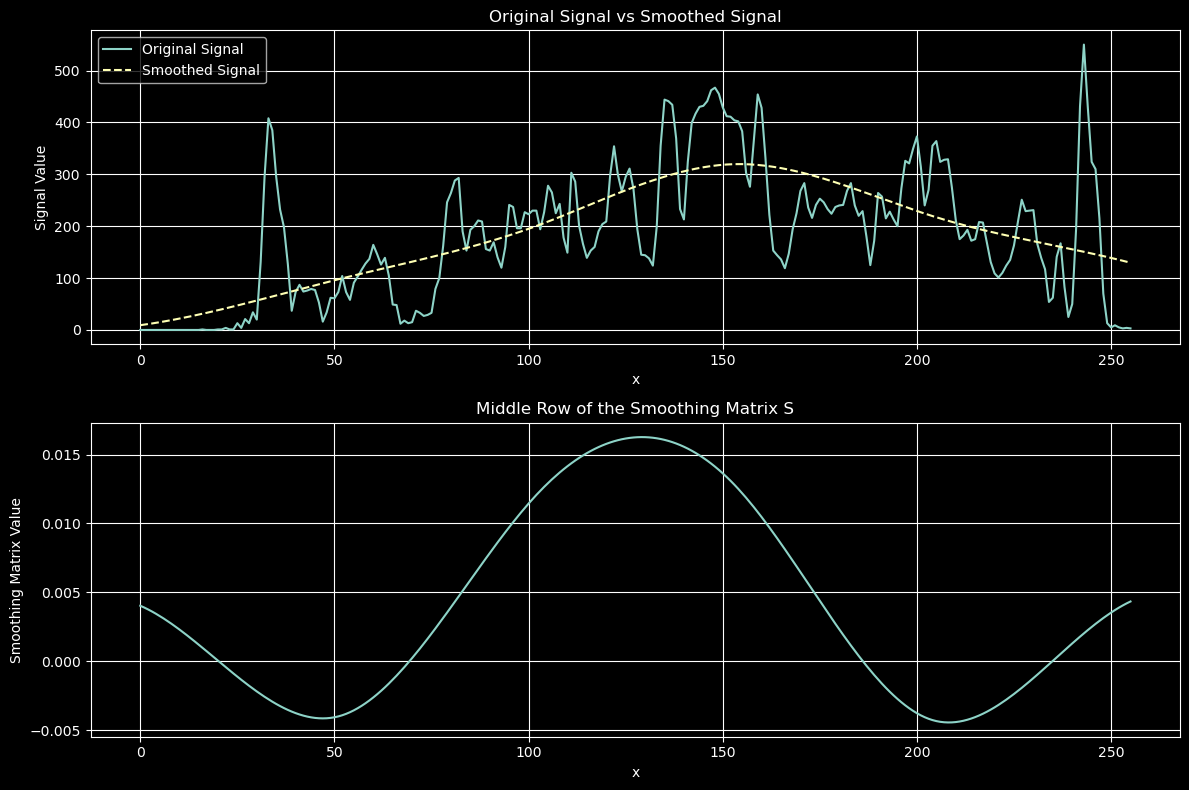

In [8]:
Phi_T_Phi = np.dot(Phi.T, Phi)
inv_Phi_T_Phi = np.linalg.inv(Phi_T_Phi)  
S = np.dot(np.dot(Phi, inv_Phi_T_Phi), Phi.T) 

t_hat = np.dot(S, t)

plt.figure(figsize=(12, 8))

# Plot the original signal and the smoothed signal
plt.subplot(2, 1, 1)
plt.plot(np.arange(N), t, label="Original Signal")
plt.plot(np.arange(N), t_hat, label="Smoothed Signal", linestyle='--')
plt.title("Original Signal vs Smoothed Signal")
plt.xlabel("x")
plt.ylabel("Signal Value")
plt.legend()
plt.grid(True)

# Plot the middle row of the smoothing matrix S
middle_row = S[N//2, :]
plt.subplot(2, 1, 2)
plt.plot(np.arange(N), middle_row)
plt.title("Middle Row of the Smoothing Matrix S")
plt.xlabel("x")
plt.ylabel("Smoothing Matrix Value")
plt.grid(True)

plt.tight_layout()
plt.show()

Now repeat the same experiment when more basis functions are used: $M=16$ and $M=52$. 

> ***Q?:*** How does the smoothing behavior change? Explain.

As  M  increases, the smoothing becomes more precise, but this can also lead to overfitting, where the smoother starts to capture noise rather than the true underlying trend of the signal

[[0.66666667 0.16666667 0.         ... 0.         0.         0.        ]
 [0.66330823 0.19770676 0.00003392 ... 0.         0.         0.        ]
 [0.65364    0.23159644 0.00027139 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.00027139 0.23159644 0.65364   ]
 [0.         0.         0.         ... 0.00003392 0.19770676 0.66330823]
 [0.         0.         0.         ... 0.         0.16666667 0.66666667]]


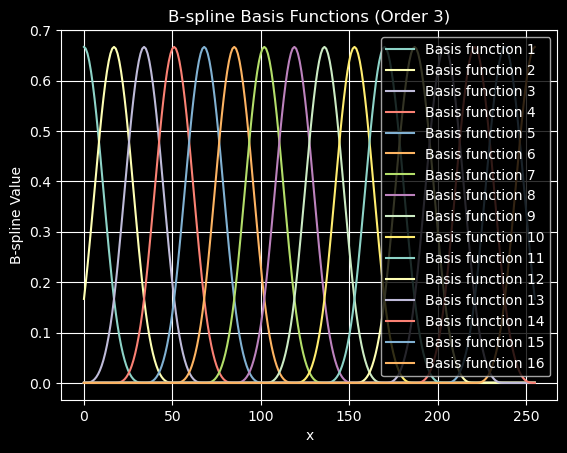

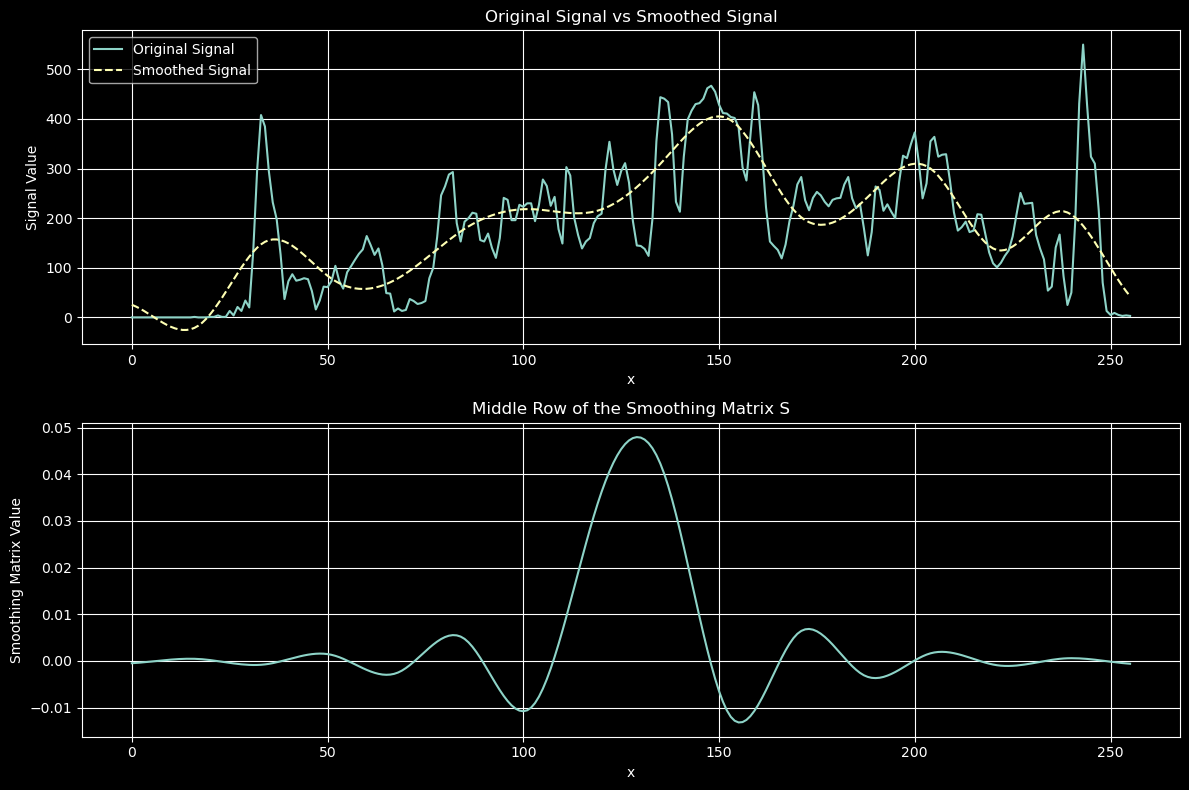

In [9]:
x = np.arange(0,256) 
N = x.shape[0]        
M = 16   
h = (N - 1) / (M - 1)  
x = x/h

# Generate the matrix Phi 
Phi = np.zeros((N, M))

for i in range(M):
    Phi[:,i] = eval_BSpline(x-i, order=3)

print(Phi)
# Plot the basis functions
plt.figure()

for m in range(M):
    plt.plot(Phi[:, m], label=f"Basis function {m+1}")

plt.title("B-spline Basis Functions (Order 3)")
plt.xlabel("x")
plt.ylabel("B-spline Value")
plt.legend()
plt.grid(True)
plt.show()

Phi_T_Phi = np.dot(Phi.T, Phi)
inv_Phi_T_Phi = np.linalg.inv(Phi_T_Phi)  
S = np.dot(np.dot(Phi, inv_Phi_T_Phi), Phi.T) 

t_hat = np.dot(S, t)

plt.figure(figsize=(12, 8))

# Plot the original signal and the smoothed signal
plt.subplot(2, 1, 1)
plt.plot(np.arange(N), t, label="Original Signal")
plt.plot(np.arange(N), t_hat, label="Smoothed Signal", linestyle='--')
plt.title("Original Signal vs Smoothed Signal")
plt.xlabel("x")
plt.ylabel("Signal Value")
plt.legend()
plt.grid(True)

# Plot the middle row of the smoothing matrix S
middle_row = S[N//2, :]
plt.subplot(2, 1, 2)
plt.plot(np.arange(N), middle_row)
plt.title("Middle Row of the Smoothing Matrix S")
plt.xlabel("x")
plt.ylabel("Smoothing Matrix Value")
plt.grid(True)

plt.tight_layout()
plt.show()

[[0.66666667 0.16666667 0.         ... 0.         0.         0.        ]
 [0.63066667 0.28266667 0.00133333 ... 0.         0.         0.        ]
 [0.53866667 0.41466667 0.01066667 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.01066667 0.41466667 0.53866667]
 [0.         0.         0.         ... 0.00133333 0.28266667 0.63066667]
 [0.         0.         0.         ... 0.         0.16666667 0.66666667]]


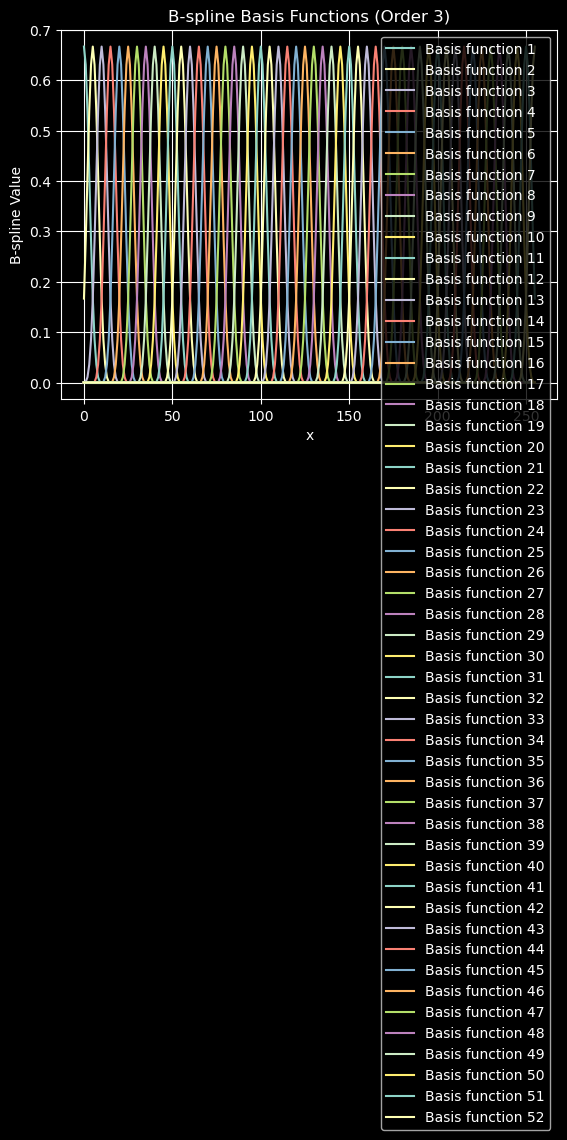

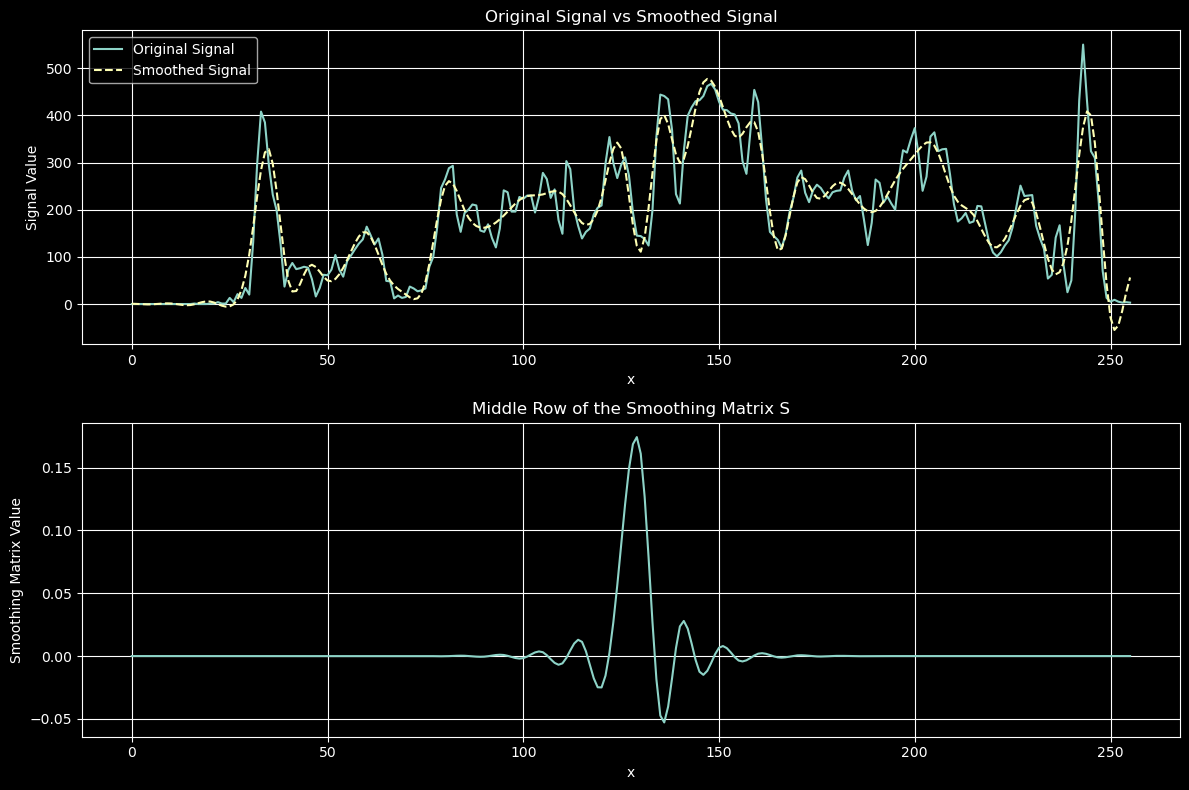

In [10]:
x = np.arange(0,256) 
N = x.shape[0]        
M = 52   
h = (N - 1) / (M - 1)  
x = x/h

# Generate the matrix Phi 
Phi = np.zeros((N, M))

for i in range(M):
    Phi[:,i] = eval_BSpline(x-i, order=3)

print(Phi)
# Plot the basis functions
plt.figure()

for m in range(M):
    plt.plot(Phi[:, m], label=f"Basis function {m+1}")

plt.title("B-spline Basis Functions (Order 3)")
plt.xlabel("x")
plt.ylabel("B-spline Value")
plt.legend()
plt.grid(True)
plt.show()

Phi_T_Phi = np.dot(Phi.T, Phi)
inv_Phi_T_Phi = np.linalg.inv(Phi_T_Phi)  
S = np.dot(np.dot(Phi, inv_Phi_T_Phi), Phi.T) 

t_hat = np.dot(S, t)

plt.figure(figsize=(12, 8))

# Plot the original signal and the smoothed signal
plt.subplot(2, 1, 1)
plt.plot(np.arange(N), t, label="Original Signal")
plt.plot(np.arange(N), t_hat, label="Smoothed Signal", linestyle='--')
plt.title("Original Signal vs Smoothed Signal")
plt.xlabel("x")
plt.ylabel("Signal Value")
plt.legend()
plt.grid(True)

# Plot the middle row of the smoothing matrix S
middle_row = S[N//2, :]
plt.subplot(2, 1, 2)
plt.plot(np.arange(N), middle_row)
plt.title("Middle Row of the Smoothing Matrix S")
plt.xlabel("x")
plt.ylabel("Smoothing Matrix Value")
plt.grid(True)

plt.tight_layout()
plt.show()

---
## Task 3: Interpolation
Implement B-spline interpolation of the 1D signal $\mathbf{t}$, by evaluating the function $y( x, \mathbf{w})$ at locations $x = [120, 120.01, 120.02, \ldots 140]$

Show your results, along with the corresponding part of the signal $\mathbf{t}$, for three different orders of B-splines: 0, 1 and 3.

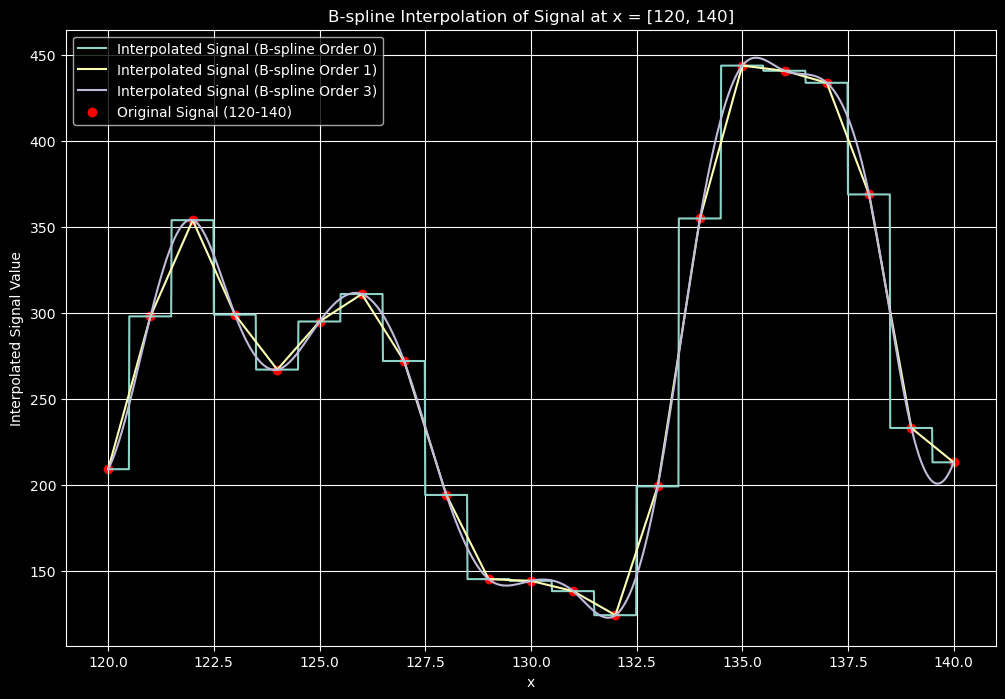

In [11]:
x_original = np.arange(0, len(t))
x_interp = np.arange(120, 140.01, 0.01)  

# def construct_Phi(x_original, x_interp, order=3):
    
#     N = len(x_original)
#     M = len(x_interp)
#     Phi = np.zeros((M, N)) # M number of interpolations, N number of original points
    
#     for i in range(N):
#         Phi[:, i] = eval_BSpline(x_interp - i, order)
    
#     return Phi

def construct_Phi(x_original, x_interp, order=3):
    """
    Constructs the Phi matrix for B-spline basis functions.
    
    Parameters:
    - x_original: Original data points
    - x_interp: Interpolation points
    - order: B-spline order (0, 1, or 3)
    
    Returns:
    - Phi: Interpolation matrix (M x N)
    """
    N = len(x_original)
    M = len(x_interp)
    
    # Scale factor (for proper spacing between basis functions)
    h = (N - 1) / (N - 1)  # Spacing factor (since we have N basis functions for N points)
    
    # Initialize Phi matrix
    Phi = np.zeros((M, N))  # M number of interpolated points, N number of original points
    
    # Construct basis functions with proper scaling
    for i in range(N):
        shifted_x = (x_interp - x_original[i]) / h  # Shift and scale the basis functions
        Phi[:, i] = eval_BSpline(shifted_x, order)
    
    return Phi

# Fit the model to compute the weights w
def compute_weights(t, x_original, x_interp, order=3):

    Phi = construct_Phi(x_original, x_original, order=order)  
    w, _, _, _ = np.linalg.lstsq(Phi, t, rcond=None)  # Solve for weights using least squares
    # Phi_T_Phi = np.dot(Phi.T, Phi)
    # inv_Phi_T_Phi = np.linalg.inv(Phi_T_Phi)
    # w = np.dot(np.dot(inv_Phi_T_Phi, Phi.T), t)
    return w

def interpolate(x_interp, x_original, w, order=3):
    
    Phi_interp = construct_Phi(x_original, x_interp, order=order)
    y_interp = np.dot(Phi_interp, w)  # Interpolate the signal using y(x) = Phi(x) * w
    return y_interp

orders = [0, 1, 3]

plt.figure(figsize=(12, 8))

for order in orders:
    w = compute_weights(t, x_original, x_interp, order=order)
    
    y_interp = interpolate(x_interp, x_original, w, order=order)
    
    plt.plot(x_interp, y_interp, label=f"Interpolated Signal (B-spline Order {order})")

# Select only the values of t between 120 and 140
t_selected = t[120:141]
x_selected = x_original[120:141]

plt.scatter(x_selected, t_selected, color='r', label="Original Signal (120-140)")


plt.title("B-spline Interpolation of Signal at x = [120, 140]")
plt.xlabel("x")
plt.ylabel("Interpolated Signal Value")
plt.legend()
plt.grid(True)
plt.show()

---
## Task 4: Smoothing in 2D
Now you are going to smooth the 2D image $\mathbf{T}$, which has dimensions $N_1 \times N_2 = 256 \times 256$, with $M_1=M_2=5$ B-spline-based 1D basis functions of order 3 for each direction.

Use the Kronecker product to produce a $N \times M$ matrix $\boldsymbol{\Phi} = \boldsymbol{\Phi}_2 \otimes \boldsymbol{\Phi}_1$, where:
- $N=N_1 N_2$ 
- $M = M_1 M_2$. 

Show a few 2D basis functions contained in the columns of $\boldsymbol{\Phi}$.

>***Hints***:
>* the Kronecker product of two matrices A and B can be calculated with ```np.kron(A, B)```
>* for converting a vectorized basis function ```v``` back into its 2D shape, use ```v.reshape(N_1, N_2, order='F')```
>* the following snippet can be used to show a 2D basis function:
>    ```
>        plt.figure(); 
>        ax = plt.axes(projection='3d'); 
>        ax.plot_wireframe(np.arange(N1).reshape(-1, 1), np.arange(N2).reshape(1, -1), basisFunction)
>
>    ```

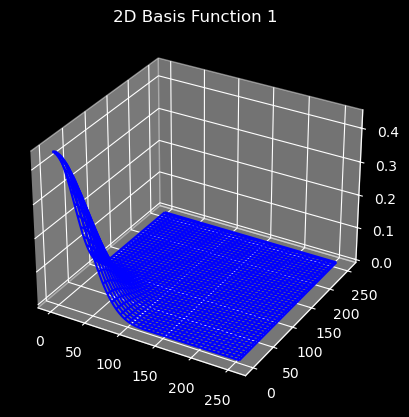

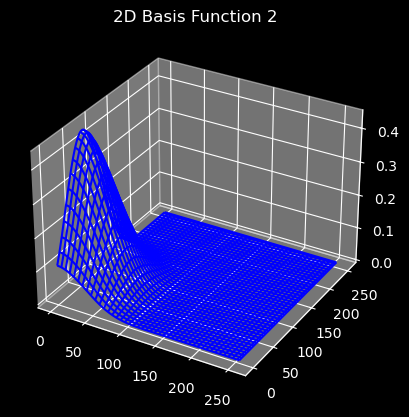

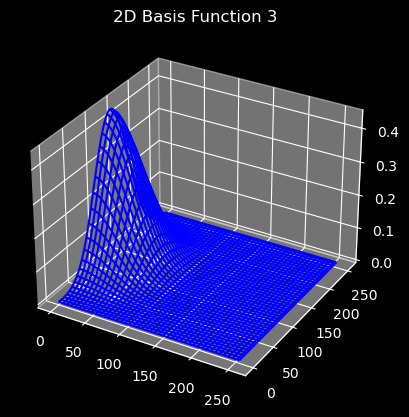

In [12]:
N1, N2 = 256, 256  # Image dimensions
M1, M2 = 5, 5      # Number of B-spline basis functions in both direction
order = 3          

def construct_1D_Phi(N, M, order):
    """
    Constructs the 1D Phi matrix of B-spline basis functions for given N and M.
    N: Number of pixels in the direction.
    M: Number of basis functions.
    order: B-spline order.
    """
    x = np.linspace(0, N - 1, N)  # Pixel coordinates
    h = (N - 1) / (M - 1)  # Spacing 
    Phi = np.zeros((N, M))

    for i in range(M):
        shifted_x = x/h - i   # Shift basis functions
        Phi[:, i] = eval_BSpline(shifted_x, order)

    return Phi

Phi_1 = construct_1D_Phi(N1, M1, order)  # rows
Phi_2 = construct_1D_Phi(N2, M2, order)  # columns

Phi = np.kron(Phi_2, Phi_1)  # 2D basis function matrix

basis_function_1 = Phi[:, 0].reshape(N1, N2, order='F')  # Reshape back to 2D form
basis_function_2 = Phi[:, 1].reshape(N1, N2, order='F')  
basis_function_3 = Phi[:, 2].reshape(N1, N2, order='F')  

def plot_2D_basis_function(basis_function, N1, N2, title="2D Basis Function"):
   
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(np.arange(N1), np.arange(N2))
    ax.plot_wireframe(X, Y, basis_function, color='blue')
    plt.title(title)
    plt.show()

plot_2D_basis_function(basis_function_1, N1, N2, title="2D Basis Function 1")
plot_2D_basis_function(basis_function_2, N1, N2, title="2D Basis Function 2")
plot_2D_basis_function(basis_function_3, N1, N2, title="2D Basis Function 3")

Now:
- vectorize the 2D image $\mathbf{T}$ into a 1D signal $\mathbf{t}$
- smooth using $\boldsymbol{\Phi}$
- re-arrange the resulting 1D signal $\mathbf{\hat{t}}$ back into a 2D image $\mathbf{\hat{T}}$
- show the result.

>***Hints***: 
>* use ```T.reshape(-1, 1, order='F')``` and ```t.reshape(N_1, N_2, order='F')``` to vectorize and undo the vectorization.
>* do not explicitly compute the smoothing matrix $\mathbf{S}$ as it is very large!! Instead compute the weights $\mathbf{w} = (\boldsymbol{\Phi}^T \boldsymbol{\Phi})^{-1} \boldsymbol{\Phi}^T \mathbf{t}$ and expand those to get $\mathbf{\hat{t}} = \boldsymbol{\Phi} \mathbf{w}$.


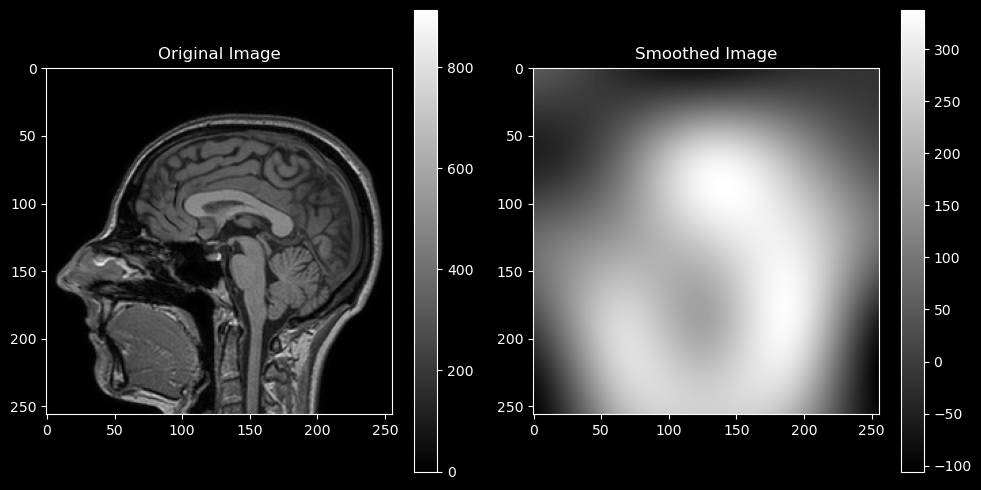

In [13]:
t = T.reshape(-1, 1, order='F')  # vectorize the image column-wise   

# Use least squares to compute the weights to avoid singular matrix error
w = np.linalg.lstsq(np.dot(Phi.T, Phi), np.dot(Phi.T, t), rcond=None)[0]

t_hat = np.dot(Phi, w)

T_hat = t_hat.reshape(N1, N2, order='F') 

plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(T, cmap='gray')
plt.title("Original Image")
plt.colorbar()

# Smoothed image
plt.subplot(1, 2, 2)
plt.imshow(T_hat, cmap='gray')
plt.title("Smoothed Image")
plt.colorbar()

plt.tight_layout()
plt.show()

Also perform the same smoothing operation by exploiting the separability of the 2D basis functions, i.e, perform row-wise and then column-wise smoothing instead. 

Show the results, and verify that they are identical (use ```np.allclose()```) 

Are the results identical?: True


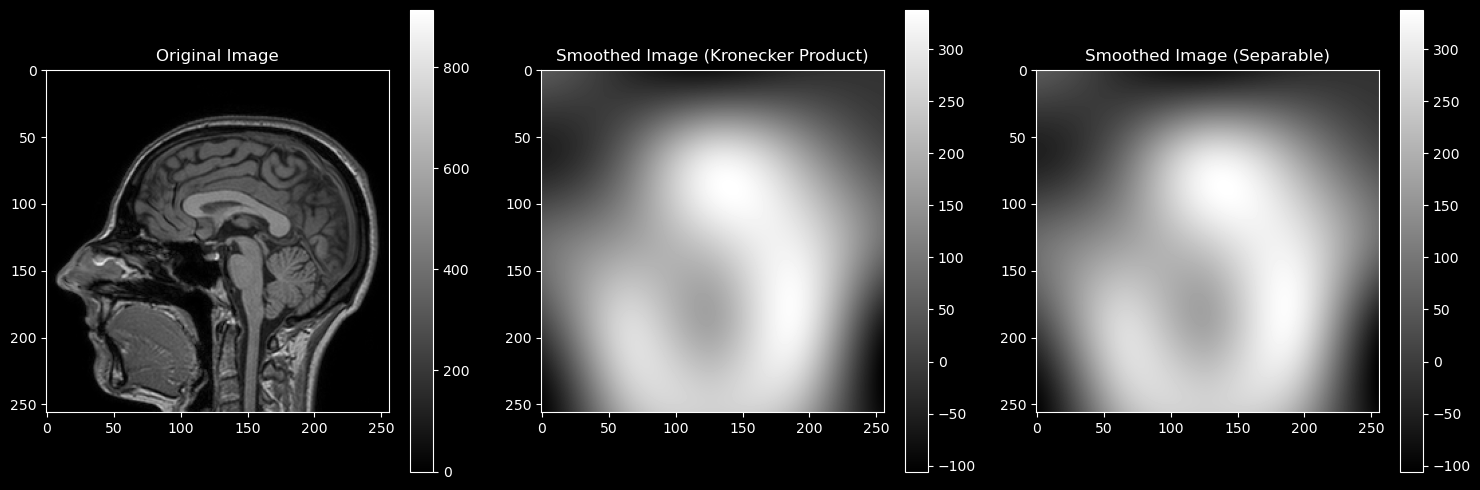

In [14]:
def row_wise_smoothing(T, Phi_1):
    
    N1, N2 = T.shape  # N1 = number of rows, N2 = number of columns
    T_smoothed_rows = np.zeros_like(T)
    
    # Loop over each row and apply smoothing
    for i in range(N1):
        row = T[i, :]  # Extract row
        w_row, _, _, _ = np.linalg.lstsq(np.dot(Phi_1.T, Phi_1), np.dot(Phi_1.T, row), rcond=None)
        T_smoothed_rows[i, :] = np.dot(Phi_1, w_row)  # Apply smoothing
    return T_smoothed_rows

def column_wise_smoothing(T_smoothed_rows, Phi_2):
    
    N1, N2 = T_smoothed_rows.shape 
    T_smoothed_cols = np.zeros_like(T_smoothed_rows)
    
    for j in range(N2):
        col = T_smoothed_rows[:, j] 
        w_col, _, _, _ = np.linalg.lstsq(np.dot(Phi_2.T, Phi_2), np.dot(Phi_2.T, col), rcond=None)
        T_smoothed_cols[:, j] = np.dot(Phi_2, w_col)  # Apply smoothing
    return T_smoothed_cols

T_smoothed_rows = row_wise_smoothing(T, Phi_1)  
T_smoothed_separable = column_wise_smoothing(T_smoothed_rows, Phi_2)  

are_identical = np.allclose(T_hat, T_smoothed_separable)  # Check if the results are identical

print("Are the results identical?:", are_identical)

plt.figure(figsize=(15, 5))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(T, cmap='gray')
plt.title("Original Image")
plt.colorbar()

# Smoothed image (Kronecker product)
plt.subplot(1, 3, 2)
plt.imshow(T_hat, cmap='gray')
plt.title("Smoothed Image (Kronecker Product)")
plt.colorbar()

# Smoothed image (Separable method)
plt.subplot(1, 3, 3)
plt.imshow(T_smoothed_separable, cmap='gray')
plt.title("Smoothed Image (Separable)")
plt.colorbar()

plt.tight_layout()
plt.show()

---
## Task 5: Interpolation in 2D
For B-spline order 0, 1 and 3, compute the weights $\mathbf{W}$ of the 2D interpolation model fitted to $\mathbf{T}$ by exploiting the separability of its basis functions.

Then show, as an image, interpolated function values $y( \mathbf{x}, \mathbf{w})$ for $\mathbf{x}=(x_1, x_2)^T$ with:
- $x_1=120.0, 120.1, 120.2 \ldots, 130.0$ 
- $x_2=120.0, 120.1, 120.2 \ldots, 130.0$ 

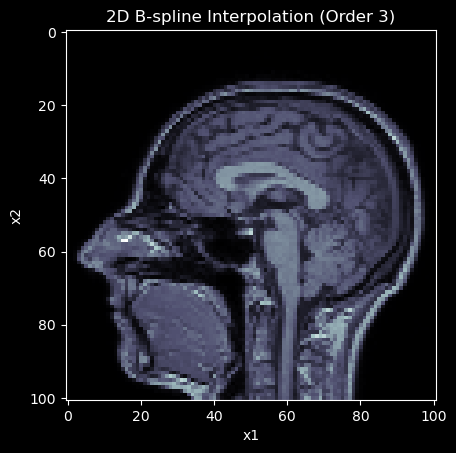

In [15]:
x1_interp = np.arange(120.0, 130.01, 0.1)  
x2_interp = np.arange(120.0, 130.01, 0.1)  

def compute_2D_weights(T, order=3):
    N1, N2 = T.shape  
    M1, M2 = 256, 256  

    Phi_1 = construct_1D_Phi(N1, M1, order)
    Phi_2 = construct_1D_Phi(N2, M2, order)

    # W = (Phi_1.T @ Phi_1)^(-1) @ Phi_1.T @ T @ Phi_2 @ (Phi_2.T @ Phi_2)^(-1)
    W, _, _, _ = np.linalg.lstsq(Phi_1, np.dot(T, Phi_2.T), rcond=None)

    return W, Phi_1, Phi_2

def interpolate_2D(x1_interp, x2_interp, W, Phi_1, Phi_2, order=3):
    N1, N2 = W.shape

    # Construct the Phi matrix for interpolation points in both directions
    Phi_1_interp = construct_1D_Phi(len(x1_interp), N1, order)
    Phi_2_interp = construct_1D_Phi(len(x2_interp), N2, order)

    # Interpolate using y(x1, x2) = Phi_1(x1) * W * Phi_2(x2).T
    y_interp = np.dot(np.dot(Phi_1_interp, W), Phi_2_interp.T)

    return y_interp

W, Phi_1, Phi_2 = compute_2D_weights(T, order=3)
y_interp = interpolate_2D(x1_interp, x2_interp, W, Phi_1, Phi_2, order=3)


plt.imshow(y_interp, cmap='bone')
plt.title("2D B-spline Interpolation (Order 3)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()
